In [2]:
# Import libraries
import numpy as np
import math
import random
import pandas as pd

import scipy.stats as stats
from statsmodels.stats.multitest import multipletests

import statsmodels.api as sm # linear regression

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import os

# Directory path
myDir = "/Users/junjie/Desktop/OneDrive - The University of Chicago (1)/Python"
save_dir = "/Users/junjie/Desktop/OneDrive - The University of Chicago (1)/Experimental data/Glycan_proxseq/manuscript/figures_svg/"
os.chdir(myDir)
import ProxseqClasses as PC
import calculateweightedPPI as WPPI
import ProxseqFunctions as PF

#*****
mpl.rcdefaults()
# Set font to be arial
mpl.rc('font', **{'sans-serif':'Arial', 'size':12})
mpl.rcParams['mathtext.rm'] = 'sans' # to have non-italic greek letter, use r'$\mathrm{\alpha}$', does NOT work with f-string
mpl.rcParams['axes.titlesize'] = 12
# Set default tick size
mpl.rcParams['xtick.major.size'] = 5.5
mpl.rcParams['ytick.major.size'] = 5.5
mpl.rcParams['xtick.minor.size'] = 2.5
mpl.rcParams['ytick.minor.size'] = 2.5
# Default legend settings
mpl.rcParams['legend.fancybox'] = False
mpl.rcParams['legend.edgecolor'] = 'k'

#to store text as text, not as path
new_rc_params = {'text.usetex': False,
                 "svg.fonttype": 'none'}
mpl.rcParams.update(new_rc_params)
#*****
# Seed number
np.random.seed(2019)
random.seed(2019)

In [3]:
data = pd.read_csv('/Users/junjie/Desktop/OneDrive - The University of Chicago (1)/Python/GPS/20240920/0920_293F_bulk_count.txt.gz',sep="\t",index_col=0)

In [3]:
all_protein_list = [
    "CD147",
    "ITGA5",
    "ITGAV",
    "EGFR",
    "CD44",
    "ITGB1",
    "EPCAM",
    "CD81",
    "CD9",
    "IgG2b",
    "IgG2a",
    "IgG1",
    "free_oligo"
]

all_lectin_list = ['PHA-L', 'ConA', 'PNA', 'MAL-I', 'MAL-II', 'SNA', 'DBA', 'ECA', 'AAL', 'DSL', 'LEL', 'GSL-II', 'free_oligo']

In [4]:
index_list = []
for protein in all_protein_list:
    for lectin in all_lectin_list:
        index_list.append(f'{protein}:{lectin}')
selected_rows = []  
for index in index_list:
    if index in data.index:
        selected_rows.append(data.loc[index])
# Create a new DataFrame from the selected rows
target = pd.DataFrame(selected_rows)
target = target.loc[~target.index.str.contains('free_oligo:free_oligo'),:]

In [5]:
pla_all = PC.plaObject(target)
pla_all.calculateProteinCount()

In [6]:
my_protein = [
    "CD147",
    "ITGA5",
    "ITGAV",
    "EGFR",
    "CD44",
    "ITGB1",
    "EPCAM",
    "CD81",
    "CD9",
    #"IgG2b",
    #"IgG2a",
    "IgG1"
]

my_lectin = ['ConA', 'PHA-L', 'DSL',  'SNA', 'MAL-I', 'MAL-II', 'AAL' , 'LEL','GSL-II','ECA','PNA','DBA' ]

In [7]:
df_protein = pla_all.protein_count.loc[my_protein]
df_lectin = pla_all.protein_count.loc[my_lectin]

In [8]:
# Define the CLR normalization function adapted from Seurat
def clr_function(column):
    # Filter out zeros for log transformation and only include positive values
    positive_values = column[column > 0]
    
    # Calculate the mean of log-transformed positive values
    mean_log = np.sum(np.log1p(positive_values)) / len(column)
    
    # Normalize by subtracting the exponential mean from each log-transformed value
    clr_values = np.log1p(column / np.exp(mean_log))
    
    return clr_values

In [9]:
#clr normalization 
clr_protein = df_protein.apply(clr_function,axis=0)
clr_lectin = df_lectin.apply(clr_function,axis=0)

/var/folders/3m/mdf183dx4b79fpz1v51zf93w0000gn/T/ipykernel_62187/90042068.py:19: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  bar_plot = sns.barplot(x='Lectin', y='CLR Normalization Count', hue='cell type', data=temp, ci='sd', capsize=0.1, errwidth=1.5, palette=custom_palette)
/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/seaborn/_oldc

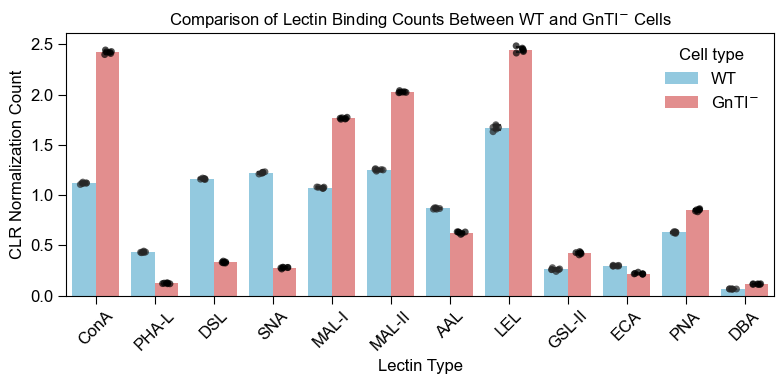

In [12]:
#barplot of glycan levels on 293F and GnTi-
# Extracting data for each cell type
lectin_293F = clr_lectin.loc[:, clr_lectin.columns.str.contains("293F")]
lectin_gnti = clr_lectin.loc[:, clr_lectin.columns.str.contains("GnTi")]

# Preparing data for plotting with individual points
temp1 = lectin_293F.T.melt(var_name='Lectin', value_name='CLR Normalization Count')
temp1['cell type'] = "WT"
temp2 = lectin_gnti.T.melt(var_name='Lectin', value_name='CLR Normalization Count')
temp2['cell type'] = r'GnTI$^{-}$'
temp = pd.concat([temp1, temp2])

custom_palette = {
    "WT": "skyblue",           # blue-like
    r"GnTI$^{-}$": "lightcoral"   # red-like
}
# Creating a bar plot with error bars and individual points
plt.figure(figsize=(8, 4))
bar_plot = sns.barplot(x='Lectin', y='CLR Normalization Count', hue='cell type', data=temp, ci='sd', capsize=0.1, errwidth=1.5, palette=custom_palette)
# Add individual points
sns.stripplot(x='Lectin', y='CLR Normalization Count', hue='cell type', data=temp, dodge=True, marker='o', alpha=0.7, jitter=0.15, color='black')

# Improve the legend to only show unique entries
handles, labels = bar_plot.get_legend_handles_labels()
plt.legend(handles[2:4], labels[0:2], title='Cell type',frameon=False)

plt.title('Comparison of Lectin Binding Counts Between WT and GnTI$^{-}$ Cells')
plt.xticks(rotation=45)
plt.ylabel('CLR Normalization Count')
plt.xlabel('Lectin Type')
#sns.despine()
plt.tight_layout()
plt.savefig(save_dir+"SI_293F_lectin_binding.svg",
            bbox_inches='tight', pad_inches=0.5)

/var/folders/3m/mdf183dx4b79fpz1v51zf93w0000gn/T/ipykernel_55076/1637355621.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(
/var/folders/3m/mdf183dx4b79fpz1v51zf93w0000gn/T/ipykernel_55076/1637355621.py:27: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(
/var/folders/3m/mdf183dx4b79fpz1v51zf93w0000gn/T/ipykernel_55076/1637355621.py:43: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(
/var/folders/3m/mdf183dx4b79fpz1v51zf93w0000gn/T/ipykernel_55076/1637355621.py:59: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


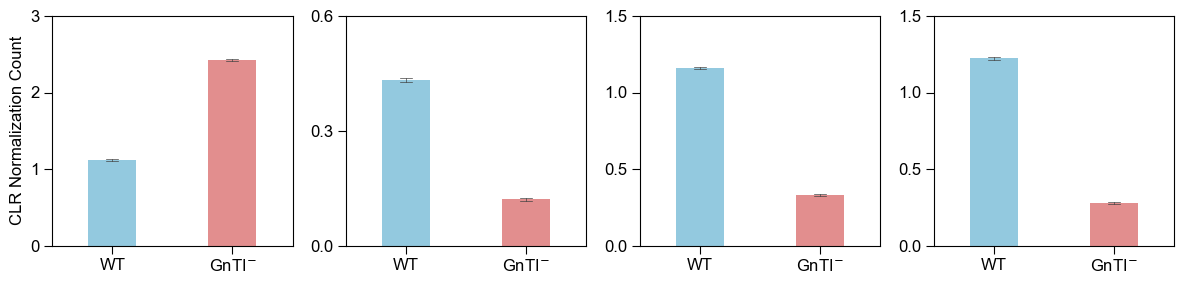

In [22]:
# Filtering data for each lectin
temp_ConA = temp[temp['Lectin'] == "ConA"]
temp_PHAL = temp[temp['Lectin'] == "PHA-L"]
temp_DSL = temp[temp['Lectin'] == "DSL"]
temp_SNA = temp[temp['Lectin'] == "SNA"]

# Creating subplots for the four lectins
fig, axes = plt.subplots(ncols=4, figsize=(12, 3))

# Plot for ConA
sns.barplot(
    x='cell type', 
    y='CLR Normalization Count', 
    data=temp_ConA, 
    ci='sd', 
    capsize=0.1, 
    errwidth=0.5, 
    palette=['skyblue', 'lightcoral'], 
    width=0.4, 
    ax=axes[0]
)
axes[0].set_xlabel('')
axes[0].set_ylabel('CLR Normalization Count')
axes[0].set_yticks([0, 1, 2, 3])

# Plot for PHA-L
sns.barplot(
    x='cell type', 
    y='CLR Normalization Count', 
    data=temp_PHAL, 
    ci='sd', 
    capsize=0.1, 
    errwidth=0.5, 
    palette=['skyblue', 'lightcoral'], 
    width=0.4, 
    ax=axes[1]
)
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_yticks([0, 0.3, 0.6])

# Plot for DSL
sns.barplot(
    x='cell type', 
    y='CLR Normalization Count', 
    data=temp_DSL, 
    ci='sd', 
    capsize=0.1, 
    errwidth=0.5, 
    palette=['skyblue', 'lightcoral'], 
    width=0.4, 
    ax=axes[2]
)
axes[2].set_xlabel('')
axes[2].set_ylabel('')
axes[2].set_yticks([0, 0.5, 1, 1.5])

# Plot for SNA
sns.barplot(
    x='cell type', 
    y='CLR Normalization Count', 
    data=temp_SNA, 
    ci='sd', 
    capsize=0.1, 
    errwidth=0.5, 
    palette=['skyblue', 'lightcoral'], 
    width=0.4, 
    ax=axes[3]
)
axes[3].set_xlabel('')
axes[3].set_ylabel('')
axes[3].set_yticks([0, 0.5, 1, 1.5])

axes[0].set_xticklabels([r'WT', r'GnTI$^{-}$'])
axes[1].set_xticklabels([r'WT', r'GnTI$^{-}$'])
axes[2].set_xticklabels([r'WT', r'GnTI$^{-}$'])
axes[3].set_xticklabels([r'WT', r'GnTI$^{-}$'])

# Styling the figure
#sns.despine()
fig.tight_layout()
fig.savefig(save_dir+"Fig1_barplot.svg",
            bbox_inches='tight', pad_inches=0)

/var/folders/3m/mdf183dx4b79fpz1v51zf93w0000gn/T/ipykernel_62187/2262258292.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  bar_plot = sns.barplot(x='Protein', y='CLR Normalization Count', hue='cell type', data=temp, ci='sd', capsize=0.1, errwidth=1.5, palette=custom_palette)
/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/seaborn/_o

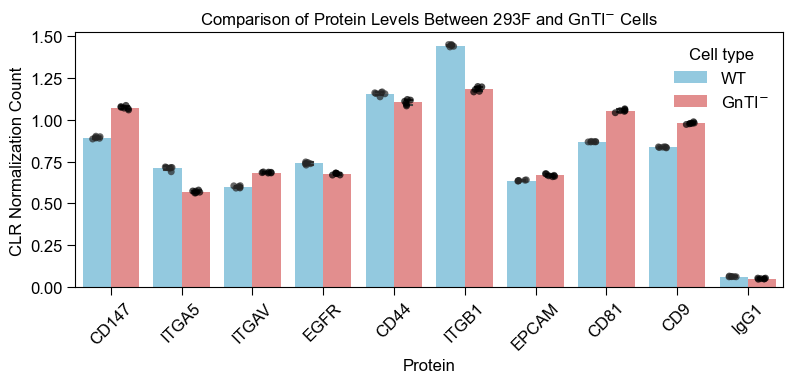

In [13]:
#barplot of protein levels on 293F and GnTi-
# Extracting data for each cell type
protein_293F = clr_protein.loc[:, clr_protein.columns.str.contains("293F")]
protein_gnti = clr_protein.loc[:, clr_protein.columns.str.contains("GnTi")]

# Preparing data for plotting with individual points
temp1 = protein_293F.T.melt(var_name='Protein', value_name='CLR Normalization Count')
temp1['cell type'] = "WT"
temp2 = protein_gnti.T.melt(var_name='Protein', value_name='CLR Normalization Count')
temp2['cell type'] = r'GnTI$^{-}$'
temp = pd.concat([temp1, temp2])

# Creating a bar plot with error bars and individual points
plt.figure(figsize=(8, 4))
bar_plot = sns.barplot(x='Protein', y='CLR Normalization Count', hue='cell type', data=temp, ci='sd', capsize=0.1, errwidth=1.5, palette=custom_palette)
# Add individual points
sns.stripplot(x='Protein', y='CLR Normalization Count', hue='cell type', data=temp, dodge=True, marker='o', alpha=0.7, jitter=0.15, color='black')

# Improve the legend to only show unique entries
handles, labels = bar_plot.get_legend_handles_labels()
plt.legend(handles[2:4], labels[0:2], title='Cell type',frameon=False)

plt.title('Comparison of Protein Levels Between 293F and GnTI$^{-}$ Cells')
plt.xticks(rotation=45)
plt.ylabel('CLR Normalization Count')
plt.xlabel('Protein')
plt.tight_layout()
#sns.despine()
plt.savefig(save_dir+"SI_293F_antibody_binding.svg",
            bbox_inches='tight', pad_inches=0.5)

In [12]:
df_temp = pla_all.pla_count.loc[~pla_all.pla_count.index.str.contains('IgG'),:].copy()
df_temp.index = df_temp.index.to_series().str.replace('free_oligo', 'Other', regex=False)

In [13]:
#extract CD147
pla_cd147 = df_temp.loc[df_temp.index.str.contains("CD147"),:]
pla_cd147 = pla_cd147.drop(index='CD147:Other')

#normalize by total lectin binding abundane of CD147
pla_cd147 = pla_cd147.div(pla_cd147.sum(axis=0), axis=1)

In [14]:
#sum complex N-glycan
pla_cd147.loc['complex_N-glycan'] = pla_cd147.loc['CD147:PHA-L',:] + pla_cd147.loc['CD147:DSL',:]

In [15]:
#sum sialylation
pla_cd147.loc['sialylation'] = pla_cd147.loc['CD147:SNA',:] + pla_cd147.loc['CD147:MAL-I',:] + pla_cd147.loc['CD147:MAL-II',:]

/var/folders/3m/mdf183dx4b79fpz1v51zf93w0000gn/T/ipykernel_55076/4163394590.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(mean_cona.index, rotation=0)
/var/folders/3m/mdf183dx4b79fpz1v51zf93w0000gn/T/ipykernel_55076/4163394590.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(mean_pahldsl.index, rotation=0)
/var/folders/3m/mdf183dx4b79fpz1v51zf93w0000gn/T/ipykernel_55076/4163394590.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[2].set_xticklabels(mean_aal.index, rotation=0)


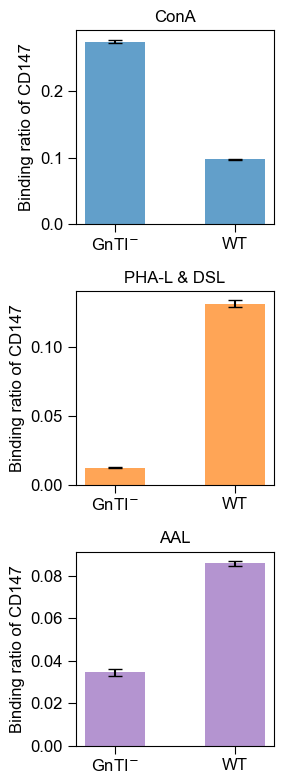

In [47]:
# Identify cell types (GnTi and 293F) from column names
labels = pla_cd147.columns
cell_types = ['GnTI$^{-}$' if 'GnTi' in label else 'WT' for label in labels]

# Create a DataFrame for easier plotting
plot_complex = pd.DataFrame({
    'Sample': labels,
    'Sum_PHA-L_DSL': pla_cd147.loc['complex_N-glycan',:].values,
    'ConA': pla_cd147.loc['CD147:ConA',:].values,
    'AAL': pla_cd147.loc['CD147:AAL',:].values,
    'Sialylation': pla_cd147.loc['sialylation'].values,
    'Cell_Type': cell_types
})

# Calculate mean and standard deviation for each glycan type by cell type
mean_pahldsl = plot_complex.groupby('Cell_Type')['Sum_PHA-L_DSL'].mean()
std_pahldsl = plot_complex.groupby('Cell_Type')['Sum_PHA-L_DSL'].std()

mean_cona = plot_complex.groupby('Cell_Type')['ConA'].mean()
std_cona = plot_complex.groupby('Cell_Type')['ConA'].std()

mean_aal = plot_complex.groupby('Cell_Type')['AAL'].mean()
std_aal = plot_complex.groupby('Cell_Type')['AAL'].std()

mean_sia = plot_complex.groupby('Cell_Type')['Sialylation'].mean()
std_sia = plot_complex.groupby('Cell_Type')['Sialylation'].std()

# Plotting three subplots with error bars
fig, axes = plt.subplots(3, 1, figsize=(3, 8))

# Subplot 1: ConA
axes[0].bar(mean_cona.index, mean_cona, yerr=std_cona, capsize=5, color='#1f77b4', alpha=0.7, width=0.5)
axes[0].set_title('ConA')
axes[0].set_ylabel('Binding ratio of CD147')
axes[0].set_xticklabels(mean_cona.index, rotation=0)

# Subplot 2: PHA-L + DSL
axes[1].bar(mean_pahldsl.index, mean_pahldsl, yerr=std_pahldsl, capsize=5, color='#ff7f0e', alpha=0.7, width=0.5)
axes[1].set_title('PHA-L & DSL')
axes[1].set_ylabel('Binding ratio of CD147')
axes[1].set_xticklabels(mean_pahldsl.index, rotation=0)

# Subplot 3: AAL
axes[2].bar(mean_aal.index, mean_aal, yerr=std_aal, capsize=5, color='#9467bd', alpha=0.7, width=0.5)
axes[2].set_title('AAL')
axes[2].set_ylabel('Binding ratio of CD147')
axes[2].set_xticklabels(mean_aal.index, rotation=0)

# Subplot 3: Sia
#axes[3].bar(mean_sia.index, mean_sia, yerr=std_sia, capsize=5, color='#2ca02c', alpha=0.7, width=0.5)
#axes[3].set_title('Sialylation')
#axes[3].set_xticklabels(mean_sia.index, rotation=0)

# Styling the figure
#sns.despine()
fig.tight_layout()
fig.savefig(save_dir+"Fig1_CD147_barplot_2.svg",
            bbox_inches='tight', pad_inches=0)

In [16]:
pla_293f = df_temp.loc[:,df_temp.columns.str.contains("293F")]
pla_gnti = df_temp.loc[:,df_temp.columns.str.contains("GnTi")]

pivot_293f = pd.DataFrame({'mean':(pla_293f).mean(axis=1)})
pivot_293f['Protein'] = [s.split(':')[0] for s in pivot_293f.index]
pivot_293f['Lectin'] = [s.split(':')[1] for s in pivot_293f.index]
pivot_293f = pivot_293f.pivot(index='Protein', columns='Lectin', values='mean')

pivot_gnti = pd.DataFrame({'mean':(pla_gnti).mean(axis=1)})
pivot_gnti['Protein'] = [s.split(':')[0] for s in pivot_gnti.index]
pivot_gnti['Lectin'] = [s.split(':')[1] for s in pivot_gnti.index]
pivot_gnti = pivot_gnti.pivot(index='Protein', columns='Lectin', values='mean')

In [17]:
#drop Other in protein and normalized data by row
pivot_293f = pivot_293f.drop(index='Other', errors='ignore').drop(columns='Other', errors='ignore')
pivot_gnti = pivot_gnti.drop(index='Other', errors='ignore').drop(columns='Other', errors='ignore')

pivot_293f_norm = pivot_293f.div(pivot_293f.sum(axis=1), axis=0)
pivot_gnti_norm = pivot_gnti.div(pivot_gnti.sum(axis=1), axis=0)

In [ ]:
plt.hist(pivot_293f_norm.loc['CD147',:])

In [55]:
protein_corr_293f = pivot_293f.T.corr()
lectin_corr_293f = pivot_293f.corr()
protein_corr_gnti = pivot_gnti.T.corr()
lectin_corr_gnti = pivot_gnti.corr()

sns.clustermap(protein_corr_293f, cmap="coolwarm", annot=True, method="average")

# Show the plot
plt.show()

sns.clustermap(protein_corr_gnti, cmap="coolwarm", annot=True, method="average")

# Show the plot
plt.show()

In [31]:
new_lectin = ['ConA', 'PHA-L', 'DSL','SNA', 'MAL-I', 'MAL-II', 'AAL','LEL','GSL-II','ECA','PNA','DBA']

In [32]:
#change the order of columns and concat two data
pivot_293f_norm = pivot_293f_norm[new_lectin]
pivot_gnti_norm = pivot_gnti_norm[new_lectin]
combined_data = pd.concat([pivot_293f_norm, pivot_gnti_norm], keys=['293F', 'GnTi'])
combined_data.index.names = ['Cell_Type', 'Protein']

In [33]:
#change cell_type name
combined_data.index = combined_data.index.set_levels(
    combined_data.index.levels[0].map(lambda x: "WT" if x == "293F" else "GnTI$^{-}$" if x == "GnTi" else x),
    level="Cell_Type")

In [34]:
combined_data = combined_data.reset_index()
combined_data['Label'] = combined_data['Cell_Type'] + '_' + combined_data['Protein']
combined_data.set_index('Label', inplace=True)

In [35]:
# Sort the DataFrame to place same proteins of different cell types next to each other
combined_data.sort_values(by=['Protein', 'Cell_Type'], ascending=[True, False], inplace=True)
combined_data.drop(columns=['Cell_Type', 'Protein'], inplace=True)

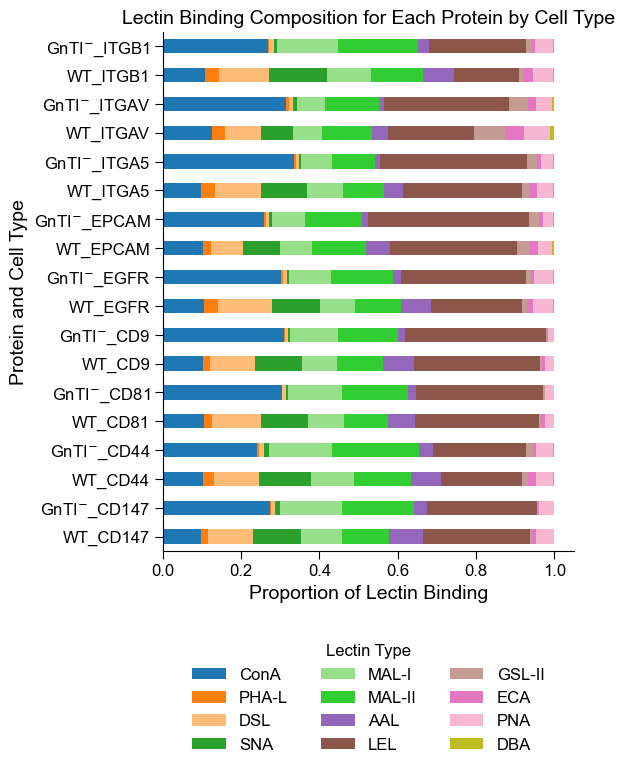

In [45]:
# Plot the data
custom_colors = [
    "#1f77b4",  # ConA: Blue
    "#ff7f0e", "#ffbb78",  # PHA-L, DSL: Orange shades
    "#2ca02c", "#98df8a", "#32CD32",  # SNA, MAL-I, MAL-II: Green/Red shades
    "#9467bd",  # AAL: Purple
    "#8c564b", "#c49c94",  # LEL, GSL-II: Brown shades
    "#e377c2", "#f7b6d2", "#bcbd22", # ECA, PNA, DBA: Pink/Olive shades
    #"#7f7f7f"  # Other: gray
]
fig, ax = plt.subplots(figsize=(6, 8))
combined_data.plot(kind='barh', stacked=True, ax=ax, color=custom_colors)

# Set titles and labels
ax.set_title('Lectin Binding Composition for Each Protein by Cell Type', fontsize=14)
ax.set_xlabel('Proportion of Lectin Binding', fontsize=14)
ax.set_ylabel('Protein and Cell Type', fontsize=14)
#ax.legend(title='Lectin Type', bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
ax.legend(
    title='Lectin Type',
    bbox_to_anchor=(0.5, -0.15),  # Centered at the bottom
    loc='upper center',
    ncol=3,  # Adjust the number of columns if needed
    frameon=False
)

fig.tight_layout()
sns.despine()
fig.savefig(save_dir+"Fig1_composition.svg",
            bbox_inches='tight', pad_inches=0)

In [26]:
combined_data

Lectin,ConA,PNA,MAL-I,MAL-II,LEL,GSL-II,PHA-L,DSL,SNA,DBA,ECA,AAL,Other
Label,,,,,,,,,,,,,
GnTi_CD147,0.217260,0.029074,0.125184,0.145033,0.220565,0.003462,0.001010,0.008771,0.010435,0.001362,0.002273,0.027364,0.208206
293F_CD147,0.074014,0.034572,0.079571,0.090369,0.208881,0.003644,0.014680,0.085395,0.094781,0.001070,0.007349,0.065389,0.240285
GnTi_CD44,0.196565,0.034845,0.132914,0.181298,0.194689,0.012797,0.002983,0.011209,0.009738,0.003582,0.006993,0.028115,0.184273
293F_CD44,0.086054,0.035585,0.091702,0.121052,0.171335,0.013641,0.023738,0.093878,0.110449,0.003380,0.016225,0.065272,0.167688
GnTi_CD81,0.233472,0.016789,0.105817,0.129747,0.248749,0.003189,0.000950,0.007759,0.004559,0.000950,0.001556,0.015329,0.231134
293F_CD81,0.075497,0.016633,0.065786,0.079757,0.226546,0.003611,0.013433,0.089130,0.085875,0.001034,0.006281,0.048360,0.288057
GnTi_CD9,0.232653,0.011074,0.091294,0.114703,0.269095,0.002768,0.000729,0.006085,0.003645,0.000868,0.001322,0.014803,0.250959
293F_CD9,0.073891,0.015431,0.065718,0.082535,0.231561,0.003038,0.011906,0.083693,0.084545,0.000923,0.006324,0.057305,0.283131
GnTi_EGFR,0.216649,0.035632,0.076722,0.113286,0.227844,0.009786,0.002172,0.007227,0.004943,0.001934,0.004488,0.014163,0.285153


In [29]:
pivot_293f

Lectin,AAL,ConA,DBA,DSL,ECA,GSL-II,LEL,MAL-I,MAL-II,Other,PHA-L,PNA,SNA
Protein,,,,,,,,,,,,,
CD147,3065.333333,3469.666667,50.166667,4003.166667,344.500000,170.833333,9792.000000,3730.166667,4236.333333,11264.166667,688.166667,1620.666667,4443.166667
CD44,4615.000000,6084.333333,239.000000,6637.500000,1147.166667,964.500000,12114.000000,6483.666667,8558.833333,11856.166667,1678.333333,2516.000000,7809.166667
CD81,2173.833333,3393.666667,46.500000,4006.500000,282.333333,162.333333,10183.500000,2957.166667,3585.166667,12948.500000,603.833333,747.666667,3860.166667
CD9,2433.000000,3137.166667,39.166667,3553.333333,268.500000,129.000000,9831.333333,2790.166667,3504.166667,12020.833333,505.500000,655.166667,3589.500000
EGFR,2004.500000,2780.166667,79.500000,3633.166667,388.833333,360.500000,6118.000000,2343.833333,3087.833333,9291.166667,910.833333,1341.666667,3238.166667
EPCAM,941.333333,1575.166667,77.666667,1243.666667,332.666667,462.000000,4956.500000,1278.166667,2068.500000,13741.000000,287.166667,564.666667,1432.166667
ITGA5,1018.833333,2047.333333,75.000000,2464.166667,363.000000,434.666667,6315.166667,1900.000000,2179.666667,12823.833333,715.333333,866.166667,2457.333333
ITGAV,531.666667,1563.166667,133.000000,1144.666667,623.333333,971.166667,2748.833333,927.500000,1601.500000,14120.833333,423.500000,837.000000,1036.500000
ITGB1,7064.333333,9798.833333,301.166667,11480.833333,2246.666667,1066.666667,14892.166667,10169.500000,11972.166667,14900.333333,3210.500000,4581.000000,13287.833333


In [ ]:
# Create a bar plot for CD147 lectin binding distribution
pivot_293f = pivot_293f[new_lectin]
pivot_gnti = pivot_gnti[new_lectin]
pivot_293f_excluding_other = pivot_293f.drop(columns=['Other'])
pivot_gnti_excluding_other = pivot_gnti.drop(columns=['Other'])
fig, ax = plt.subplots(nrows=2, figsize=(5,6))
ax[0].bar(pivot_293f_excluding_other.columns, pivot_293f_excluding_other.loc['CD147',:], edgecolor='black')
ax[0].set_title('Lectin Binding Distribution (293F_CD147)')
ax[0].set_ylabel('Raw Binding UMI')
ax[0].tick_params(axis='x', rotation=45, labelsize=10)

ax[1].bar(pivot_gnti_excluding_other.columns, pivot_gnti_excluding_other.loc['CD147',:], edgecolor='black')
ax[1].set_title('Lectin Binding Distribution (GnTi-_CD147)')
ax[1].set_ylabel('Raw Binding UMI')

ax[1].set_xlabel('Lectins')
ax[1].tick_params(axis='x', rotation=45, labelsize=10)
fig.tight_layout()
sns.despine()

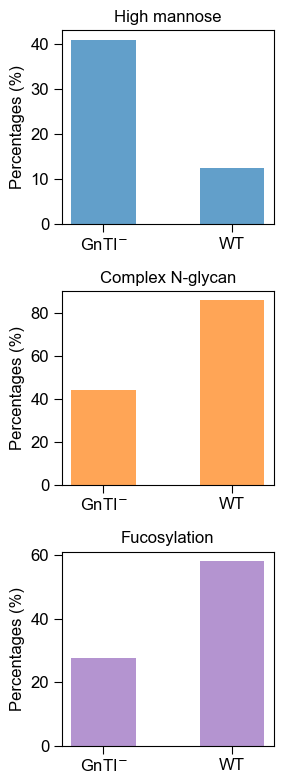

In [64]:
# DataFrames for glycomics data
mannose_bar = pd.DataFrame({'Cell type': ['GnTI$^{-}$', 'WT'],
                            'Percentages (%)': [40.90, 12.44]})
nglycan_bar = pd.DataFrame({'Cell type': ['GnTI$^{-}$', 'WT'],
                            'Percentages (%)': [44.44, 86.07]})
fucose_bar = pd.DataFrame({'Cell type': ['GnTI$^{-}$', 'WT'],
                           'Percentages (%)': [27.71, 58.15]})

# Data preparation
cell_types = mannose_bar['Cell type']
categories = ['High mannose', 'Complex N-glycan', 'Fucosylation']
percentages = [mannose_bar['Percentages (%)'], 
               nglycan_bar['Percentages (%)'], 
               fucose_bar['Percentages (%)']]

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(3, 8))

# Colors for each category
colors = ['#1f77b4', '#ff7f0e', '#9467bd']

# Plot each category in a separate subplot
for ax, category, percent, color in zip(axes, categories, percentages, colors):
    x = np.arange(len(cell_types))
    ax.bar(x, percent, color=color, width=0.5, alpha=0.7)
    
    # Add labels and title
    ax.set_title(f'{category}',fontsize=12)
    #ax.set_xlabel('Cell Type', fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(cell_types, fontsize=12)
    #ax.set_ylim(0, 100)  # Set a consistent y-axis scale
    ax.set_ylabel('Percentages (%)', fontsize=12)
    
    # Add value labels above bars
    #for i, value in enumerate(percent):
    #    ax.text(x[i], value + 2, f"{value:.1f}%", ha='center', fontsize=10)

# Adjust layout for better spacing
fig.tight_layout()
fig.savefig(save_dir+"Fig1_CD147_MS_barplot.svg",
            bbox_inches='tight', pad_inches=0)